In [1]:
import numpy as np
import torch
import torch.optim as optim

import cv2
import scipy.ndimage
import os

import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets
from torchvision import transforms
import torch.utils.data as data

from timeit import default_timer as timer
import random
from random import shuffle

import matplotlib.pyplot as plt  
%matplotlib inline

from PIL import Image

In [154]:
def load_images_from_folder(folder):
    images = {}
    for filename in os.listdir(folder):
        if filename == '.DS_Store':
          print(filename)
        else:
          img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images[filename.split('.')[0]] = img  #remove extension from file name
    return images

In [155]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [4]:
train_data_1 = load_images_from_folder("../data/Training-Dataset/Resize-Augmented-Masks/1/")
train_data_2 = load_images_from_folder("../data/Training-Dataset/Resize-Augmented-Masks/2/")
train_data_3 = load_images_from_folder("../data/Training-Dataset/Resize-Augmented-Masks/3/")
train_data_4 = load_images_from_folder("../data/Training-Dataset/Resize-Augmented-Masks/4/")
train_data_5 = load_images_from_folder("../data/Training-Dataset/Resize-Augmented-Masks/5/")

In [156]:
train_data = load_images_from_folder("../data/Training-Dataset/Resize-Augmented-Predicted-Masks/")
test_data  = load_images_from_folder("../data/Validation-Dataset/Predicted-Masks/")

In [0]:
test_data_1 = load_images_from_folder("/content/drive/My Drive/Resize-Augmented-Predicted-Masks/1/")
test_data_2 = load_images_from_folder("/content/drive/My Drive/Resize-Augmented-Predicted-Masks/2/")
test_data_3 = load_images_from_folder("/content/drive/My Drive/Resize-Augmented-Predicted-Masks/3/")
test_data_4 = load_images_from_folder("/content/drive/My Drive/Resize-Augmented-Predicted-Masks/4/")
test_data_5 = load_images_from_folder("/content/drive/My Drive/Resize-Augmented-Predicted-Masks/5/")

In [157]:
def resizeData(images, width=256, height=256, filter=True, kernel_size=5):
    resize = {}
    for key in images.keys(): 
        image = images[key].copy()
        
        if filter:
            image = cv2.GaussianBlur(image, (kernel_size, kernel_size),0 )
        
        resize[key] = cv2.resize(image, (width, height), interpolation = cv2.INTER_AREA)
        
    return resize


In [158]:
def augmentData(data, folderName, augment = True):
  augmentation = {}  
  print("augmenting")
  
  if augment:
    for key in data.keys():
      for i in range(0,360,40):
        augmentation[str(key) + 'rotation' + str(i)] = scipy.ndimage.rotate(data[key], i, reshape=False, cval = 255, mode='constant')  
  else:
    augmentation = data 
  
  print("resizing")  
  resize = resizeData(augmentation, filter = False)

  augmented = []
  labels = []
  for key_ in resize.keys():
    inv = 255-resize[key_]
    img = inv.clip(max=1)
    #print(np.unique(img))
    augmented.append(img)
    labels.append(np.array(folderName-1))
  
  
  return np.array(augmented), np.array(labels)

In [159]:
def labeledImages(images): 
    return [int(key[0])-1 for key in images.keys()]

In [160]:
aug1, lab1 = augmentData(train_data_1, 1, augment=False)
aug2, lab2 = augmentData(train_data_2, 2, augment=False)
aug3, lab3 = augmentData(train_data_3, 3, augment=False)
aug4, lab4 = augmentData(train_data_4, 4, augment=False)
aug5, lab5 = augmentData(train_data_5, 5, augment=False)

augmenting
resizing
augmenting
resizing
augmenting
resizing
augmenting
resizing
augmenting
resizing


In [161]:
aug_train,_ =  augmentData(train_data,1, augment=False)
labels_train = labeledImages(train_data)

augmenting
resizing


In [162]:
aug_test,_ =  augmentData(test_data,1, augment=False)
labels_test = labeledImages(test_data)

augmenting
resizing


In [163]:
len(labels_train)

360

In [164]:
aug1_val, lab1_val = augmentData(test_data_1, 1, augment=False)
aug2_val, lab2_val = augmentData(test_data_2, 2, augment=False)
aug3_val, lab3_val = augmentData(test_data_3, 3, augment=False)
aug4_val, lab4_val = augmentData(test_data_4, 4, augment=False)
aug5_val, lab5_val = augmentData(test_data_5, 5, augment=False)

NameError: name 'test_data_1' is not defined

In [165]:
aug = np.concatenate((aug1,aug2,aug3,aug4,aug5))
labels = np.concatenate((lab1,lab2,lab3,lab4,lab5))

In [166]:
aug_val = np.concatenate((aug1_val,aug2_val,aug3_val,aug4_val,aug5_val))
labels_val = np.concatenate((lab1_val,lab2_val,lab3_val,lab4_val,lab5_val))

NameError: name 'aug1_val' is not defined

In [167]:
np.unique(aug1[4,:,:,0])

array([0, 1], dtype=uint8)

In [18]:
aug[0,:,:,0] == 1

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True]])

In [19]:
plt.imshow(aug1[120,:,:,0])

IndexError: ignored

In [113]:
tensor_x = torch.FloatTensor(aug_train) # transform to torch tensor
tensor_y = torch.LongTensor(labels_train)

my_dataset = data.TensorDataset(tensor_x.permute(0,3,1,2),tensor_y) # create your datset
trainloader = data.DataLoader(my_dataset, batch_size=60, shuffle = True) # create your dataloader


In [114]:
tensor_x_val = torch.FloatTensor(aug_test) # transform to torch tensor
tensor_y_val = torch.LongTensor(labels_test)

my_dataset_val = data.TensorDataset(tensor_x_val.permute(0,3,1,2),tensor_y_val) # create your datset
validloader = data.DataLoader(my_dataset_val, batch_size=60, shuffle = True) # create your dataloader


In [115]:
iter_ = iter(trainloader)
bimg, blabel = next(iter_)

print('Batch Label shape: ', blabel.shape)
print('The Batched tensors return a collection of {} RGB images ({} channel, {} height pixels, {} width pixels)'.format(bimg.shape[0],
                                                                                                                        bimg.shape[1],
                                                                                                                       bimg.shape[2],
                                                                                                                        bimg.shape[3]))
print('In the case of the labels, we obtain {} batched integers, one per image'.format(blabel.shape[0]))

Batch Label shape:  torch.Size([60])
The Batched tensors return a collection of 60 RGB images (3 channel, 256 height pixels, 256 width pixels)
In the case of the labels, we obtain 60 batched integers, one per image


In [116]:
class conv_block(nn.Module):
    def __init__(self,ch_in,ch_out):
        super(conv_block,self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out,track_running_stats=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch_out, ch_out, kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out,track_running_stats=False),
            nn.ReLU(inplace=True)
        )

    def forward(self,x):
        x = self.conv(x)
        return x


In [147]:
class BigNet(nn.Module):
  
  def __init__(self):
    super().__init__()
    
    self.conv1 = nn.Conv2d(1, 2 , 3, 1, padding=1)
    self.conv_bn_1 = nn.BatchNorm2d(4)
    self.conv2 = nn.Conv2d(2, 4, 3, 1, padding=1)
    self.conv_bn_2 = nn.BatchNorm2d(8)    
    self.conv3 = nn.Conv2d(4, 8 , 3, 1, padding=1)
    self.conv_bn_3 = nn.BatchNorm2d(16)
    self.conv4 = nn.Conv2d(8, 16 , 3, 1, padding=1)
    self.conv_bn_4 = nn.BatchNorm2d(32)

    self.pool  = nn.MaxPool2d(2,2)
    self.act   = nn.ReLU(inplace=False)
    self.drop = nn.Dropout2d(0.1)    
    
    self.mlp = nn.Sequential(
        nn.Linear(16 * 16 * 16, 128),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(128,5),        
        nn.Softmax(dim=-1)    
    )
 
    
  def forward(self, x):
    x = self.conv_bn_1(self.conv1(x))
    x = self.pool(self.act(x))
    x = self.drop(x)

    x = self.conv_bn_2(self.conv2(x))
    x = self.pool(self.act(x))
    x = self.drop(x)

    x = self.conv_bn_3(self.conv3(x))
    x = self.pool(self.act(x))
    x = self.drop(x)

    x = self.conv_bn_4(self.conv4(x))
    x = self.pool(self.act(x))
    x = self.drop(x)

    bsz, nch, height, width = x.shape
    x = x.view(bsz, -1)
    
    y = self.mlp(x)

    return y

In [148]:
def model_params(model):
    # from: https://discuss.pytorch.org/t/how-do-i-check-the-number-of-parameters-of-a-model/4325/6
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

In [149]:
cnn = BigNet()
print(model_params(cnn))
cnn.to(device)

526741


BigNet(
  (conv1): Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_bn_1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(2, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_bn_2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_bn_3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_bn_4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (act): ReLU()
  (drop): Dropout2d(p=0.1, inplace=False)
  (mlp): Sequential(
    (0): Linear(in_features=4096, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=128

In [152]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn.parameters(), lr=0.1, momentum = 0.2)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 25, gamma = 0.1)
epochs = 50
steps = 0
running_loss = 0
train_losses = []
test_losses = []
print_every = 3

In [153]:
for epoch in range(epochs):
    for inputs, labels in trainloader:
        accuracy_train = 0
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs[:,0,:,:]
        inputs = inputs.unsqueeze(dim=1)
        optimizer.zero_grad()
        logps = cnn.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        batch_loss = criterion(logps, labels)
        test_loss += batch_loss.item()
                    
        #ps = torch.exp(logps)
        top_p, top_class = logps.topk(1, dim=1)
        #print(top_class[1:10], logps[1:10])
        equals = top_class == labels.view(*top_class.shape)
        accuracy_train += torch.mean(equals.type(torch.FloatTensor)).item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            cnn.eval()
            with torch.no_grad():
                for inputs_val, labels_val in validloader:
                    #print(labels[0])
                    inputs_val, labels_val = inputs_val.to(device), labels_val.to(device)
                    
                    inputs_val = inputs_val[:,0,:,:]
                    inputs_val = inputs_val.unsqueeze(dim=1)
                    
                    logps = cnn.forward(inputs_val)

                    batch_loss = criterion(logps, labels_val)
                    test_loss += batch_loss.item()
                    
                    #ps = torch.exp(logps)
                    top_p, top_class = logps.topk(1, dim=1)
                    #print(top_class[1:10], logps[1:10])
                    equals = top_class == labels_val.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(validloader))                    
            
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Train accuracy:{accuracy_train:.3f}.. "
                  f"Test loss: {test_loss/len(validloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(validloader):.3f}")
                
            running_loss = 0
            cnn.train()


torch.save(cnn, 'cnn_finger.pth')

RuntimeError: running_mean should contain 2 elements not 4

In [ ]:
print(cnn.forward(inputs_val)[40], labels_val[40])

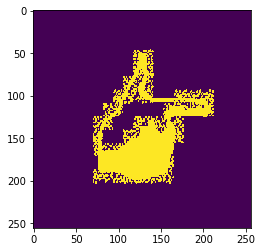

In [135]:
plt.imshow((inputs_val)[40][0,:,:].cpu())

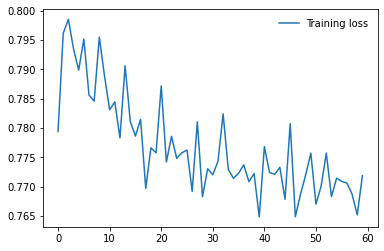

In [36]:
plt.plot(train_losses, label='Training loss')
#plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()